In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [16]:
ab_data = pd.read_csv('data/ab_data.zip')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [17]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [18]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [19]:
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id': 'count',
    'converted': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [20]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
daily_data.head(10)

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361
5,2017-01-04,B,6538,763,11.670236
6,2017-01-05,A,6419,791,12.322792
7,2017-01-05,B,6509,743,11.414964
8,2017-01-06,A,6604,762,11.538462
9,2017-01-06,B,6735,834,12.383073


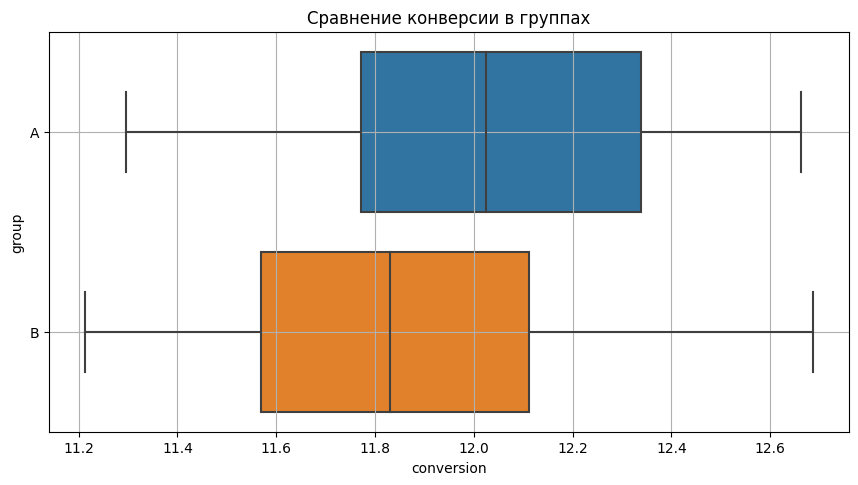

In [21]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

In [22]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Медиана и среднее почти одинаковы, а значит, выбросов в данных нет, а разница в 0.3%, что очень несущественно.

In [23]:
line = px.line(
    daily_data,
    x='timestamp',
    y='conversion',
    color='group',
    title='График конверсии по дням'
)
line.show()

По такому графику невозможно сделать выводов, т.к. значения скачат изо дня в день. Нужно использовать график кумулятивной конверсии.

In [24]:
daily_data_a = daily_data[daily_data['group'] == 'A'].copy()
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()
daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head()

,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Кумулятивная сумма - накопительная сумма, где каждое её значение - результат сложения показателя за предыдущие дни с показателем за текущий день.

$ S_{t} = S_{t-1} + x{_t} $
* $ x_{t} $ - значение показателя в день $t$
* $ S_{t} $ - значение суммы в день $t$

In [25]:
daily_data['cum_users_count'] = daily_data.groupby('group')['users_count'].cumsum()
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count
0,2017-01-02,A,2851,357,12.521922,2851
1,2017-01-02,B,2848,339,11.903090,2848
2,2017-01-03,A,6584,749,11.376063,9435
3,2017-01-03,B,6620,754,11.389728,9468
4,2017-01-04,A,6573,797,12.125361,16008


In [26]:
daily_data['cum_converted'] = daily_data.groupby('group')['converted'].cumsum()
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted
0,2017-01-02,A,2851,357,12.521922,2851,357
1,2017-01-02,B,2848,339,11.903090,2848,339
2,2017-01-03,A,6584,749,11.376063,9435,1106
3,2017-01-03,B,6620,754,11.389728,9468,1093
4,2017-01-04,A,6573,797,12.125361,16008,1903


In [27]:
daily_data['cum_conversion'] = daily_data['cum_converted'] / daily_data['cum_users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


In [28]:
cum_conv = px.line(
    daily_data,
    x='timestamp',
    y='cum_conversion',
    color='group',
    title='График кумулятивной конверсии по дням'
)
cum_conv.show()

Конверсия группы В хуже конверсии группы А на всём промежутке времени.

# Статистический тест для конверсии

$H_{0} : p_{a} = p_{b}$, то есть истинные пропорции в группах равны.

$H_{1} (двусторонняя): p_{a} \neq p_{b}$, то есть истинные пропорции в группах не равны.

$H_{1} (левостороняя): p_{a} < p_{b}$

$H_{1} (правосторонняя): p_{a} > p_{b}$

Применим z-test для пропорций

In [29]:
from statsmodels.stats.proportion import proportions_ztest

* `count` - количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
* `nobs ` - количество наблюдений (в каждой из групп), то есть размер выборки.
* `alternative` - альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'.

In [34]:
converted_piv = ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


In [39]:
h_0 = 'Конверсии в группах А и В равны'
# На графике видно, что группа А выше, чем В, это мы и будем проверять
h_1 = 'Конверсия в группе А выше, чем конверсия в группе В'
alpha = 0.05
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число успехов
    nobs=converted_piv['count'], # всего наблюдений
    alternative='larger'
)
print('p-value:', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(h_0))
    print("Альтернативная гипотеза. H1: {}".format(h_1))
else:
    print("Принимаем нулевую гипотезу. {}".format(h_0))

p-value: 0.1
Принимаем нулевую гипотезу. Конверсии в группах А и В равны


# Статистические тесты для других метрик

In [41]:
time_data = pd.read_excel('data/time_data.xlsx')
time_data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


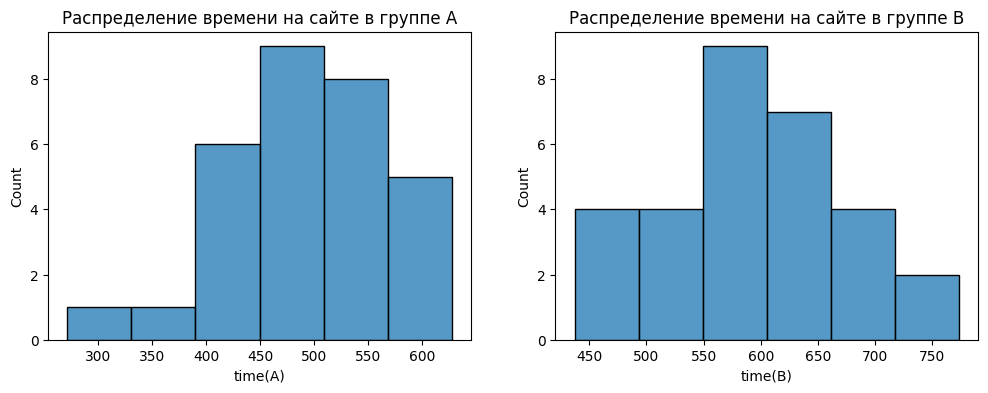

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [46]:
from scipy.stats import shapiro
from scipy.stats import ttest_ind

In [45]:
h_0 = 'Распределения в обеих группах нормальные'
h_1 = 'Распределения в одной или обеих группах отлично от нормального'
alpha = 0.05
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А:', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(h_0))
    print("Альтернативная гипотеза. H1: {}".format(h_1))
else:
    print("Принимаем нулевую гипотезу. {}".format(h_0))

p-value группы А: 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [47]:
h_0 = 'Среднее время в группах одинаково'
h_1 = 'Среднее время в группе А меньше, чем в группе В'
alpha = 0.05
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
if results.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {h_0}')
    print(f'Альтернативная гипотеза. H1: {h_1}')
else:
    print(f'Принимаем нулевую гипотезу. {h_0}')

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе В
